In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats as st
import scipy.spatial.distance as dist
from sklearn.metrics import accuracy_score
import time
sns.set_style('whitegrid')

## 1. Implementing Coordinate Descent

In [2]:
# reading the data
with open('regression.npy', 'rb') as f:
    X = np.load(f) #loading the features
    y = np.load(f) #loading the targets

In [3]:
#splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### a. Simple Linear Regression with Coordinate Descent

In [4]:
class Coordinate_Descent:
    def __init__(self, X, y, L1=None):
        #for normalizing features
        self.scalar = StandardScaler().fit(X)
        self.X = np.append(np.ones(X.shape[0]).reshape(-1,1),self.scalar.transform(X),1)
        self.y = y.reshape(-1,1)
        self.n = self.X.shape[1]
        self.alpha = 1 #value for L1 penalty
        self.L1 = L1 #L1 check
    
    #soft function to aid feature updation using Lasso
    def soft_func(self,x,e):
        if x>e:
            return x - e
        elif x<-e:
            return x + e
        else:
            return 0
    
    def fit(self):
        max_iter = 100 #maximum number of iterations
        tolerance = 1e-6 #tolerance
        B = np.zeros(self.n).reshape(-1,1) #initial betas
        B_history = np.zeros(shape=(1,self.n)) #for making the history of Betas
        
        #iterating till max_iterations
        for it in range(max_iter):
            B_old = B.copy() #make a copy of beta to compare with new ones to check the amount of change
            for i in range(self.n): #optimizing over one feature at a time
                X_i = np.delete(self.X,i,axis=1) #All features except the i-th feature
                B_i = np.delete(B,i,axis=0) #All Betas except the i-th beta

                #To update the beta vector
                update = np.divide(((self.y - X_i@B_i).T @ self.X[:,i]),self.X[:,i].T @ self.X[:,i])
                
                #if doing L1 regularization
                if self.L1:
                    #penalty term
                    penalty = np.divide(1/2*self.alpha,self.X[:,i].T @ self.X[:,i])
                    #soft function outputs the optimized value, here depending on inputs the feature can be set to exactly 0
                    B[i] = self.soft_func(update,penalty)
                else:
                    B[i] = update
            
            #for making the history of Beta values
            B_history = np.vstack((B_history,B.reshape(-1)))
            #to know by how much the value changed
            e = B-B_old
            #stop loop once updation becomes insignificant
            if np.all(np.abs(e) < tolerance):
                self.B = B
                return B,B_history
        
        self.B = B
        return B,B_history
    
    def predict(self,x):
        return np.append(np.ones(x.shape[0]).reshape(-1,1),self.scalar.transform(x),1) @ self.B

Fitting the model on the training data

In [5]:
#without regularization
unreg_CD = Coordinate_Descent(X_train,y_train,L1=False)
b_unreg, b_hist_unreg= unreg_CD.fit()

#with regularization
reg_CD = Coordinate_Descent(X_train,y_train,L1=True)
b_reg, b_hist_reg= reg_CD.fit()

Plotting the values of $\beta$ against the number of iterations for unregularized case

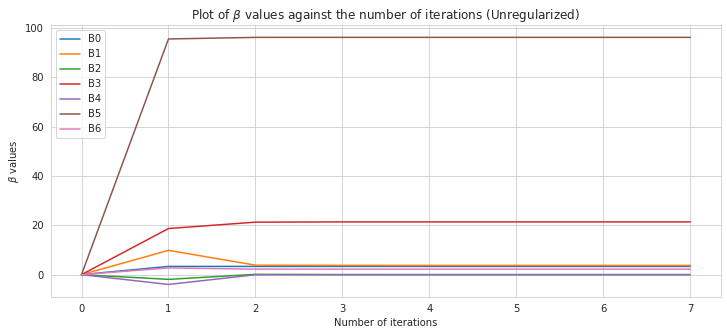

In [6]:
b_hist_unreg = pd.DataFrame(b_hist_unreg,columns=['B0','B1','B2','B3','B4','B5','B6'])
ax = b_hist_unreg.plot(figsize=(12,5),\
title=r'Plot of $\beta$ values against the number of iterations (Unregularized)');
ax.set_xlabel("Number of iterations");
ax.set_ylabel(r"$\beta$ values");

Plotting the values of $\beta$ against the number of iterations for regularized case

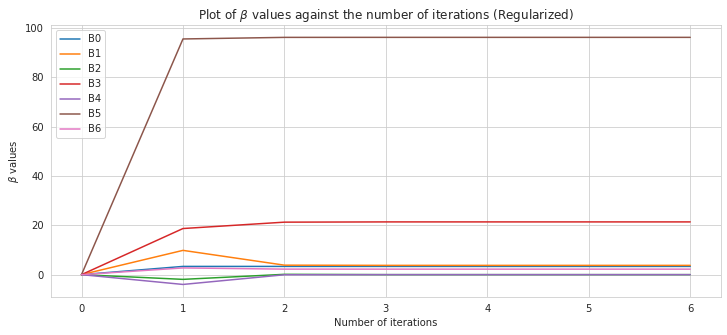

In [7]:
b_hist_reg = pd.DataFrame(b_hist_reg,columns=['B0','B1','B2','B3','B4','B5','B6'])
ax = b_hist_reg.plot(figsize=(12,5),\
title=r'Plot of $\beta$ values against the number of iterations (Regularized)');
ax.set_xlabel("Number of iterations");
ax.set_ylabel(r"$\beta$ values");

**Question:** Compare the plots of the unregularized and regularized CD

Here the graph looks same for both regularized and unregularized case, however, once we zoom into the final output of the values in the two cases, we can see the difference.

In [8]:
#for unregularized case
b_hist_unreg.iloc[-1,:]

B0     3.333237
B1     3.753771
B2     0.000234
B3    21.363149
B4     0.000107
B5    96.127483
B6     2.218797
Name: 7, dtype: float64

In [9]:
#for regularized case
b_hist_reg.iloc[-1,:]

B0     3.332612
B1     3.753158
B2     0.000000
B3    21.362537
B4     0.000000
B5    96.126869
B6     2.218154
Name: 6, dtype: float64

Here we can see that, the values of B2 and B4 have reached exactly 0 in case of Lasso while for the normal regression case, it is close to 0 but not exactly 0. This is the property of Lasso Regression that it makes weights/slope of unnecessary features equal to 0 so that in the analysis they are excluded. For other parameters the optimum value is more or less similar. The Lasso model also converged faster than our normal regression model based on our stopping criteria.

**Question:** How is the Coordinate Descent method different from SGD and Newton’s method? In which case is it
advisable to use the CD method?

The Coordinate Descent method is different in a way that it treats an optimization problem as a 1-D sub problem and optimizes one variable at a time. Newton and SGD methods optimizes for all variable at a same time. Also, in the case of CD no step length is required. In cases where the function is not differentiable at every point, it is recommended to use coordinate descent, however, coordinate descent is not perfect and prone to stucking before global minima in cases where the level curves of a function is not smooth. Also, for the cases where a 1-d subproblem can be solved analytically CD can give boost in convergance.

## 2. Accelerating K-Nearest Neighbour Classifier

In [10]:
# reading the data
with open('classification.npy', 'rb') as f:
    X = np.load(f) #loading the features
    y = np.load(f) #loading the targets

In [11]:
#splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [13]:
class KNN:
    def __init__(self, X, y, K, distance_metric):
        self.X = X
        self.y = y #targets
        self.K = K #num neighbors
        self.N = X.shape[0]
        self.M = X.shape[1]
        self.dist_metric = distance_metric #distance metric to be used
    
    
    def predict(self,x):
        y_pred = np.empty(x.shape[0])
        c1 = 0
        #iterating over each testing example
        for samp in x:
            #this calculates the distance of the sample with whole training data
            d = np.empty(self.N)
            c2 = 0
            for train_sample in self.X:
                d[c2] = self.dist_metric(samp,train_sample)
                c2+=1
            #to get the classes of the top K nearest neighbors
            neighbor_classes = self.y[d.argsort()[:self.K]]
            #assigning the majority class in the neighbors, if there is no majority, assign the class of closest neighbor
            cls,freq = st.mode(neighbor_classes)

            y_pred[c1] = cls
            
            c1+=1
        return y_pred
    
    
    def predict_partial_distance(self,x):
        y_pred = np.empty(x.shape[0])
        c1 = 0
        
        for test_sample in x:
            dk = np.empty(self.K)
            
            #calculating the distance with the first K neighbors
            for n in range(self.K):
                dk[n] = self.dist_metric(test_sample,self.X[n,:])
            
            #to sort an array
            ind = dk.argsort()
            
            #now iterating over rest of the training examples
            for n in range(self.K,self.N):
                d = 0
                m = 0
                dk_max = np.max(dk)
                dk_argmax = np.argmax(dk)
                
                while (m < self.M) and (d < dk_max):
                    d = self.dist_metric(test_sample[0:m],np.array(self.X[n,0:m]))
                    m+=1
                    
                if d < dk_max:
                    dk[dk_argmax] = d
                    ind[dk_argmax] = n
                    
            #to get the classes of the top K nearest neighbors       
            neighbor_classes = self.y[ind]
            #assigning the majority class in the neighbors, if there is no majority, assign the class of closest neighbor
            cls,freq = st.mode(neighbor_classes)
            y_pred[c1] = cls 
            c1 +=1
            
        return y_pred

In [14]:
class HashTables:
    def __init__ (self, X, y, key_size, num_tables):
        self.X = X
        self.y = y
        self.k = key_size #dimension of projections or size of key
        self.t = num_tables #number of tables
        self.d = X.shape[1]
        
    def create_key(self, x, key_gen):
        key = (np.dot(x,key_gen)>0).astype(np.int8) #Encoding random projections into a key
        hash_keys = [''.join(o.astype('str')) for o in key] #making a single string key for each sample
        return hash_keys
    
    def create_hash_keys(self):
        key_gen = np.random.randn(self.k,self.d).T #Random Projections
        hash_keys = self.create_key(self.X, key_gen) #generating the keys of training examples
        return hash_keys, key_gen
    
    def create_hash_tables(self):
        tables = [] #to store all hash tables
        key_gens = [] #to store all key generators
        
        for _ in range(self.t):
            
            #hash table with each key generator
            table = {}
            
            #create hash keys for each hash table
            hash_keys,key_gen = self.create_hash_keys()
            
            #store indexes of examples which fall into same bin
            for i,v in enumerate(hash_keys):
                table[v] = table.get(v,list()) + [i]
            
            #once a complete hash table is created add it with other hash tables
            tables.append(table)
            
            #store the key generator too
            key_gens.append(key_gen)
        
        return tables,key_gens

In [15]:
class LSH:
    def __init__(self, X, y, K, k, num_tables, distance_metric):
        self.scalar = StandardScaler().fit(X)
        self.X = self.scalar.transform(X) #features
        self.y = y #targets
        self.K = K #num neighbors
        self.k = k #dimension of projection/ key size
        self.n_tables = num_tables #number of hashtables
        self.N = X.shape[0]
        self.M = X.shape[1]
        self.dist_metric = distance_metric #distance metric to be used
        self.maj_class, _ = st.mode(self.y)
        
    def fit(self):
        self.h = HashTables(self.X, self.y, self.k, self.n_tables)
        self.tables, self.key_gens = self.h.create_hash_tables()

    def predict(self,x):
        y_pred = np.empty(x.shape[0])
        
        #iterating over each test sample
        for c1,test_samp in enumerate(x):
            ind = [] #to store the indices of neighbors which appear togather in atleast one hash table
            
            #iterating over each table and finding the potential neighbors of each test example
            for gen,table in zip(self.key_gens,self.tables):
                test_samp = test_samp.reshape(1,-1)
                key = self.h.create_key(test_samp,gen)[0] #creaitng the key of test example
                ind = set(table.get(key,list())).union(set(ind)) #to get indices of neighbors
            
            #to get the features of only subset of training samples    
            x_subset = self.X[list(ind)]
            #incase if the test sample does not have any neighbor in its bucket set its class same as majority class
            if len(x_subset)<1:
                y_pred[c1] = self.maj_class
                continue

            d = {}
            
            #iterating over each sample in the subset
            for c2, train_samp in zip(list(ind),x_subset):
                d[c2] = self.dist_metric(test_samp.reshape(-1),train_samp.reshape(-1))  
             
            #to sort the dictionary by values
            d = dict(sorted(d.items(), key=lambda x: x[1]))
            
            #to get the classes of the top K nearest neighbors
            neighbor_classes = self.y[list(d.keys())[:self.K]]
            
            #assigning the majority class in the neighbors
            cls,freq = st.mode(neighbor_classes)

            y_pred[c1] = cls
            
        return y_pred

Calculating the accuracy and runtime on test set with Vanilla KNN and Cityblock Distance

In [16]:
accuracy_knn = []
Time_knn = []
for k in range(1,8):
    #making the KNN model
    m = KNN(X_train_scaled,y_train,k,dist.cityblock)
    i = time.time()
    p = m.predict(X_test_scaled)
    t = time.time()-i
    accuracy_knn.append(accuracy_score(y_test,p))
    Time_knn.append(t)

Calculating the accuracy and runtime on test set with Partial Distance KNN and Cityblock Distance

In [17]:
accuracy_pd = []
Time_pd = []
for k in range(1,8):
    #making the KNN model
    m = KNN(X_train_scaled,y_train,k,dist.cityblock)
    i = time.time()
    p = m.predict_partial_distance(X_test_scaled)
    t = time.time()-i
    accuracy_pd.append(accuracy_score(y_test,p))
    Time_pd.append(t)

Calculating the accuracy and runtime on test set with LSH KNN and Cityblock Distance

In [22]:
accuracy_lsh = []
Time_lsh = []
for k in range(1,8):
    #making the KNN model
    m = LSH(X_train_scaled,y_train,k,10,100,dist.cityblock)
    m.fit()
    i = time.time()
    p = m.predict(X_test_scaled)
    t = time.time()-i
    accuracy_lsh.append(accuracy_score(y_test,p))
    Time_lsh.append(t)

Let's make a DataFrame to compare the results

In [25]:
d = pd.DataFrame(columns=np.arange(1,8),index=['Vanilla KNN','Partial Distance','LSH'])
d.iloc[0,:] = accuracy_knn
d.iloc[1,:] = accuracy_pd
d.iloc[2,:] = accuracy_lsh
print('Comparision in terms of Accuracy')
d.head()

Comparision in terms of Accuracy


,1,2,3,4,5,6,7
Vanilla KNN,0.705,0.745,0.785,0.79,0.8,0.795,0.79
Partial Distance,0.715,0.74,0.775,0.755,0.79,0.805,0.81
LSH,0.74,0.735,0.74,0.755,0.81,0.805,0.82


In [26]:
d = pd.DataFrame(columns=np.arange(1,8),index=['Vanilla KNN','Partial Distance','LSH'])
d.iloc[0,:] = Time_knn
d.iloc[1,:] = Time_pd
d.iloc[2,:] = Time_lsh
print('Comparision in terms of Time')
d.head()

Comparision in terms of Time


,1,2,3,4,5,6,7
Vanilla KNN,1.25079,1.707122,1.739809,2.098978,1.877764,1.874154,2.080858
Partial Distance,78.331132,74.073418,73.936682,74.38257,74.884179,76.251585,77.082296
LSH,0.710937,0.76998,0.676706,0.703429,0.693342,0.701654,0.695716


In [30]:
distances = [dist.cosine, dist.euclidean, dist.cityblock]
d = pd.DataFrame(index=['Vanilla KNN','Partial Distance','LSH'],columns=['Cosine','Euclidean','CityBlock'])

for i,dt in enumerate(distances):
    
    #vanilla Knn
    vanilla = KNN(X_train_scaled,y_train,2,dt)
    p = vanilla.predict(X_test_scaled)
    d.iloc[0,i] = accuracy_score(y_test,p)
    
    #partial distance knn
    par_d = KNN(X_train_scaled,y_train,2,dt)
    p = par_d.predict_partial_distance(X_test_scaled)
    d.iloc[1,i] = accuracy_score(y_test,p)
    
    #LSH
    lsh = LSH(X_train_scaled,y_train,2,10,100,dt)
    lsh.fit()
    p = lsh.predict(X_test_scaled)
    d.iloc[2,i] = accuracy_score(y_test,p)

print('Comparision in terms of Metric')
d.head()

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Comparision in terms of Metric


,Cosine,Euclidean,CityBlock
Vanilla KNN,0.835,0.76,0.745
Partial Distance,0.695,0.735,0.74
LSH,0.8,0.745,0.73


**Question:** How is the NN algorithm different from the algorithms we have studied so far?

**Answer:** They are different in a way that they are very simple yet effective. They do not have any parameters and therefore no learning is involved. They can be used for both classification and regression tasks and give decent enough performance. The only drawback is their computation speed and memory requirements. Since they memorize whole data so take large space depending on the size of data and computation is often expensive because of large number of comparisions to be made.